In [1]:
import os
import sys
import importlib
os.chdir("../..")
directory_path = os.path.abspath(os.path.join("src"))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import EyeTraumaAnalysis

In [2]:
importlib.reload(EyeTraumaAnalysis);

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import cv2

In [4]:
image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
image.img = cv2.cvtColor(image.img, cv2.COLOR_BGR2HSV)
# image = cv2.cvtColor(image.img, cv2.COLOR_BGR2RGB) # Change color to RGB (from BGR)
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.img.reshape((-1,3))
# Convert to float type only for supporting cv2.kmean
pixel_vals = np.float32(pixel_vals)

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 10 # Choosing number of cluster
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [6]:
labels.shape

(99840, 1)

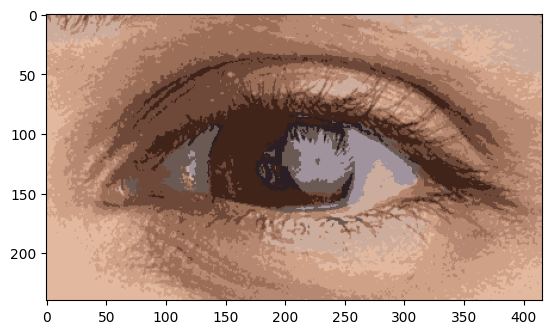

In [7]:
centers = np.uint8(centers) # convert data into 8-bit values
orig_centers = centers

# import math
# l = len(centers)
# incr = 255 / l
# color = math.floor(incr)
# for i in range(l):
#     centers[i] = [color, color, color]
#     color = math.floor(color + incr)

segmented_data = centers[labels.flatten()] # Mapping labels to center points( RGB Value)

segmented_image = segmented_data.reshape((image.img.shape)) # reshape data into the original image dimensions

segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_HSV2BGR)

plt.imshow(segmented_image, vmin=0, vmax=255)
# plt.imshow(segmented_image)

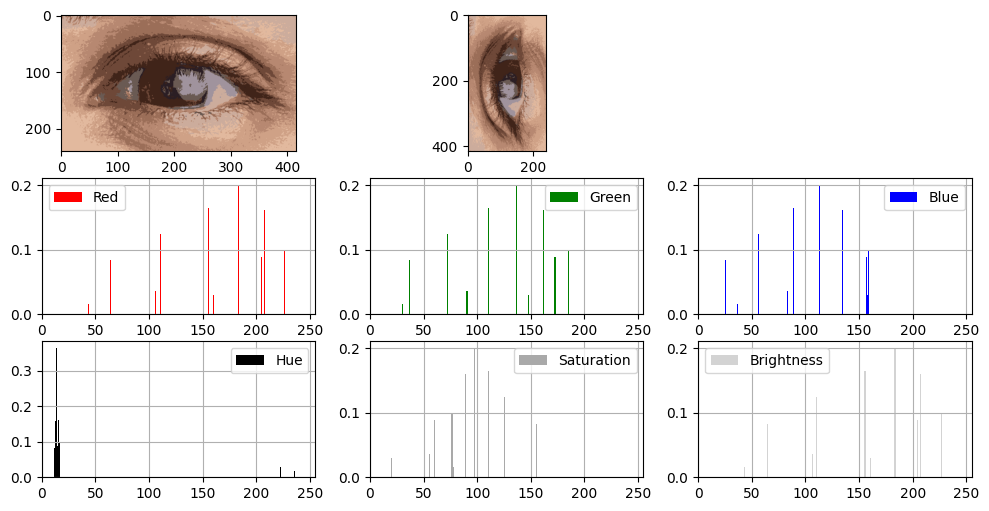

In [11]:
image = segmented_image

img_hsv = mpl.colors.rgb_to_hsv(segmented_image[...,:3]/255.0) * 255

fig, axs = plt.subplots(3, 3, figsize=(12,6))

axs[0,0].imshow(image)

axs[0,1].imshow(np.transpose(segmented_image, axes=[1,0,2]))
axs[0,2].axis("off")

axs[1,0].hist(image[...,0].ravel(),256,[0,256],density=True, facecolor="red", label="Red");
axs[1,1].hist(image[...,1].ravel(),256,[0,256],density=True, facecolor="green", label="Green");
axs[1,2].hist(image[...,2].ravel(),256,[0,256],density=True, facecolor="blue", label="Blue");

axs[2,0].hist(img_hsv[...,0].ravel(),256,[0,256],density=True, facecolor="black", label="Hue");
axs[2,1].hist(img_hsv[...,1].ravel(),256,[0,256],density=True, facecolor="darkgray", label="Saturation");
axs[2,2].hist(img_hsv[...,2].ravel(),256,[0,256],density=True, facecolor="lightgray", label="Brightness");

for ind, ax in enumerate(axs[1:,:].reshape(-1)):
    ax.grid()
    ax.set_xlim([0, 255])
    ax.legend()

In [30]:
image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
img_hsv = cv2.cvtColor(image.img[...,:3], cv2.COLOR_RGB2HSV)
ht, wd, ch = img_hsv.shape;
center = (int(wd/2),int(ht/2));
bottom_region_cutoff = int(ht*95/100)
kernel = np.ones((int(wd/50),int(ht/50)),np.uint8)
# get bottom region as ground truth for skin
region_hsv1 = img_hsv[bottom_region_cutoff:,:,:3]  # :3 removes alpha channel
percentiles1 = np.quantile(region_hsv1,[0.01, 0.99], axis=[0,1])

In [60]:
centers[0]

array([111, 125, 110], dtype=uint8)

In [59]:
cv2.cvtColor(centers[0], cv2.COLOR_HSV2BGR)

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,-1,-1>,struct cv::impl::A0x2b45e655::Set<3,4,-1>,struct cv::impl::A0x2b45e655::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [82]:
(cv2.cvtColor(segmented_image[:,:,:3], cv2.COLOR_BGR2HSV)==centers[6]).dtype

dtype('bool')

In [86]:
skin_threshold = cv2.inRange(cv2.cvtColor(segmented_image[:,:,:3], cv2.COLOR_BGR2HSV),
                             centers[9],
                             centers[9])
skin_threshold = np.zeros(skin_threshold.shape[0:3], dtype="uint8")
skin_threshold[] == 1
#skin_threshold = (cv2.cvtColor(segmented_image[:,:,:3], cv2.COLOR_BGR2HSV)==centers[6]).astype(np.int64)
target1 = cv2.bitwise_and(image.img,image.img, mask=~skin_threshold)
print(np.count_nonzero(skin_threshold))
plt.imshow(target1)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [94]:
skin_threshold.reshape([-1,3])
#https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python
masked_image = np.copy(cv2.cvtColor(image.img, cv2.COLOR_BGR2HSV))
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))
# color (i.e cluster) to disable
cluster = 2
masked_image[labels == cluster] = [0, 0, 0]
# convert back to original shape
masked_image = masked_image.reshape(image.shape)
plt.imshow(masked_image)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 1

In [91]:
np.logical_and(
    cv2.cvtColor(segmented_image[:,:,0], cv2.COLOR_BGR2HSV)==centers[6,1],
              cv2.cvtColor(segmented_image[:,:,1], cv2.COLOR_BGR2HSV)==centers[6,2], axis=-1
              #cv2.cvtColor(segmented_image[:,:,2], cv2.COLOR_BGR2HSV)==centers[6,3]
)

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x2b45e655::Set<3,-1,-1>,struct cv::impl::A0x2b45e655::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [92]:
cv2.cvtColor(segmented_image[:,:,1], cv2.COLOR_BGR2HSV)==centers[6,2].shape

error: OpenCV(4.6.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x2b45e655::Set<3,-1,-1>,struct cv::impl::A0x2b45e655::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1
